# Fine-tuning BERT on long texts

In this notebook we explore different approach to overcome one of the main limitation of BERT (which stands for Bidirectional Encoder Representations from Transformers), the ability to process long document. In fact BERT can only be applied on text that have less than 512 token after tokenization with the Bert Tokenizer.


&nbsp;


We will implement [this paper, which introduce a new method to deal with Long Documents : RoBERT (Recurrence over BERT)](https://arxiv.org/abs/1910.10781).



We will also implement [this paper, which introduce diferents methods to deal with Long Documents and BERT](https://arxiv.org/abs/1905.05583) to see if the RoBERT paper bring some significative improvement on the classification of Long Texts with BERT.

This paper introduce 2 main approaches, the **Truncation methods** and the **Hierarchical methods** :
 * Truncation methods
   * head-only
   * tail-only
   * head+tail
 * Hierarchical methods
   * mean pooling
   * max pooling
 
The Truncation methods applies to the input of the BERT model (the Tokens), while the Hierarchical methods applies to the ouputs of the Bert model (the embbeding), we will go into more detail in the respective parts


&nbsp;


The goal of the original RoBERT article was to solve the following problem: BERT has a fixed input token count; how can we use its power on long texts. This notebook implements the same approach using HuggingFace's `transformers` library and `pytorch`.

The dataset used is the *US Consumer Finance Complaints* available on [Kaggle](https://www.kaggle.com/cfpb/us-consumer-finance-complaints).

Basically, the article goes as follows:
1. Read the data and do some basic preprocessing
2. Break the documents into smaller segments with a number of tokens that can be handled by BERT
3. Fine-tune BERT on those segments using a classification head
4. Combine the segments of each document by using an LSTM. The fixed output size of the LSTM can be used by a single fully connected layer for the final classification.


&nbsp;


For code clarity, we separated out some parts of the code into python scripts that are fully commented. They will be referenced throughout the notebook.

Here is a graph that represents the differents Interaction between the differents Classes :

![img/Class_Interactions.png](img/Class_Interactions.png)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import transformers
from transformers import RobertaTokenizer, BertTokenizer, RobertaModel, BertModel, AdamW# get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
import time

from utils import *
from Custom_Dataset_Class import ConsumerComplaintsDataset1
from Bert_Classification import Bert_Classification_Model
from RoBERT import RoBERT_Model

from BERT_Hierarchical import BERT_Hierarchical_Model
import warnings
warnings.filterwarnings("ignore")

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:1")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Data Exploration :

The dataset used in this work was retrieved from kaggle as said in the paper, these are consumer complaints about financial products and services which are sent by the CFPB (Consumer FinancialProtection  Bureau)  to  the  company  for  answer.

The  dataset  consists  of  555957  rows  and  18columns. 

As our model attempts to predict which product the complaint is about, we only used the consumer-complaint-narrative and product columns.
* comsumer-complaint-narrative:  contains the consumer complaint in text format.
* product:  label of the product concerned by the complaint\

The final dataset used in this work consists of 555957 rows and 2 columns (one column for the texts and the other for the labels).

In [67]:
# FinArg

# Load the dataset into a pandas dataframe.
df=pd.read_json("./augmented_data/gpt3_5_context_extracted.json")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

train_raw = df
print('Number of training sentences with complain narrative not null: {:,}\n'.format(train_raw.shape[0]))

# Display 10 random rows from the data.
# train_raw.columns = ['text', 'label']
train_raw.sample(10)

Number of training sentences: 7,753

Number of training sentences with complain narrative not null: 7,753



,sentences,labels,generated,augmented_sentences,preceding_sentences,following_sentences
1250,I talked about in some detail the security val...,0,"Preceding sentences: \n\nDuring this quarter, ...",I talked about in some detail the security val...,"During this quarter, we had some exciting upda...",Our team has been working relentlessly to impr...
7336,And then that’s all just on Azure.,0,Preceding sentence: We are seeing tremendous g...,And then that’s all just on Azure.,We are seeing tremendous growth in our cloud c...,"Additionally, we are continuing to invest in e..."
4184,We're excited about the number of customers th...,1,Preceding sentence: Our latest product release...,We're excited about the number of customers th...,Our latest product release has been generating...,"As a result, we are seeing a significant uptic..."
6439,One of the things I would point out is that fr...,0,"Preceding: ""Now, turning to our revenue outloo...",One of the things I would point out is that fr...,"Now, turning to our revenue outlook for the ne...","However, despite these challenges, we remain c..."
1789,I’m sorry I skipped over that gross margin que...,0,"Preceding sentences: ""We've received a lot of ...",I’m sorry I skipped over that gross margin que...,We've received a lot of questions today regard...,We attribute the increase in gross margins to ...
2737,"And on a sequential basis, when we look into t...",1,Preceding sentence: Our international operatio...,"And on a sequential basis, when we look into t...",Our international operations have been a signi...,"Despite the currency headwinds, we remain opti..."
2287,"And so the other things that you named, whethe...",1,"Preceding: ""We're now going to open the call u...","And so the other things that you named, whethe...",We're now going to open the call up to questio...,"Looking ahead, we're excited to continue expan..."
1565,And so the inherent volatility that you are ta...,1,Preceding sentence:\nWe've noticed that there'...,And so the inherent volatility that you are ta...,We've noticed that there's been some concern a...,"That being said, we're confident in our abilit..."
2047,And the link to basically do the messaging is ...,1,Preceding sentence: We're now going to open up...,And the link to basically do the messaging is ...,We're now going to open up the call for questi...,"So, we're actively working on improving that i..."
7055,"And so, in order to have that local compute in...",0,"Preceding sentences: ""We've been seeing a lot ...","And so, in order to have that local compute in...",We've been seeing a lot of interest in our Azu...,We're continuing to invest in Azure Stack to m...


In [51]:
# Load the dataset into a pandas dataframe.
df=pd.read_csv("./us-consumer-finance-complaints/consumer_complaints.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

train_raw = df[df.consumer_complaint_narrative.notnull()]
print('Number of training sentences with complain narrative not null: {:,}\n'.format(train_raw.shape[0]))

# Display 10 random rows from the data.
train_raw.sample(10)

Number of training sentences: 555,957

Number of training sentences with complain narrative not null: 66,806



,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
299865,09/22/2015,Credit card,NaN,APR or interest rate,NaN,On my Care Credit account I had some promotion...,NaN,Synchrony Financial,NY,132XX,NaN,Consent provided,Web,09/22/2015,Closed with explanation,Yes,No,1574545
514169,11/05/2015,Prepaid card,Government benefit payment card,Unauthorized transactions/trans. issues,NaN,"I am one of Rush card user, I have been really...",NaN,"Empowerment Ventures, LLC",LA,712XX,NaN,Consent provided,Web,11/06/2015,Closed with monetary relief,Yes,No,1641945
509698,01/22/2016,Student loan,Non-federal student loan,Dealing with my lender or servicer,Trouble with how payments are handled,I attended University XXXX at XXXX for two yea...,NaN,"Navient Solutions, Inc.",UT,841XX,NaN,Consent provided,Web,01/22/2016,Closed with explanation,Yes,No,1753981
254231,06/25/2015,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,I am a homeowner in the state of Va. I am curr...,Company chooses not to provide a public response,U.S. Bancorp,VA,236XX,NaN,Consent provided,Web,06/25/2015,Closed with explanation,Yes,No,1437607
539518,04/07/2016,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",NaN,I have been trying to come to a resolution for...,Company believes it acted appropriately as aut...,"Select Portfolio Servicing, Inc",CA,926XX,NaN,Consent provided,Web,04/07/2016,Closed with explanation,Yes,Yes,1868877
306278,10/21/2015,Credit reporting,NaN,Credit monitoring or identity protection,Billing dispute,CONSUMER : XXXX XXXXCOMPLAINT : TRANSUNION AND...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",CA,913XX,NaN,Consent provided,Web,10/21/2015,Closed with explanation,Yes,Yes,1619069
509284,02/15/2016,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,Mortgage was approved for 2MP program in conju...,Company disputes the facts presented in the co...,"West Coast Servicing, Inc.",MI,481XX,NaN,Consent provided,Web,03/23/2016,Closed with explanation,Yes,No,1787834
514547,02/10/2016,Credit card,NaN,Billing disputes,NaN,I have XXXX accounts with Wells Fargo. The acc...,Company chooses not to provide a public response,Wells Fargo & Company,DE,197XX,NaN,Consent provided,Web,02/10/2016,Closed with explanation,Yes,Yes,1779058
210058,04/07/2015,Credit reporting,NaN,Incorrect information on credit report,Reinserted previously deleted info,I believe that XXXX XXXX XXXX XXXX ( XXXX ) is...,NaN,Equifax,OK,735XX,NaN,Consent provided,Web,04/27/2015,Closed with explanation,Yes,Yes,1319609
227801,04/25/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,I have disputed this XXXX times. I did n't sig...,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",KS,667XX,NaN,Consent provided,Web,04/25/2015,Closed with explanation,Yes,No,1347356


<Axes: title={'center': "nombre d'ocurence par nombre de mots dans un commentaire"}, ylabel='Frequency'>

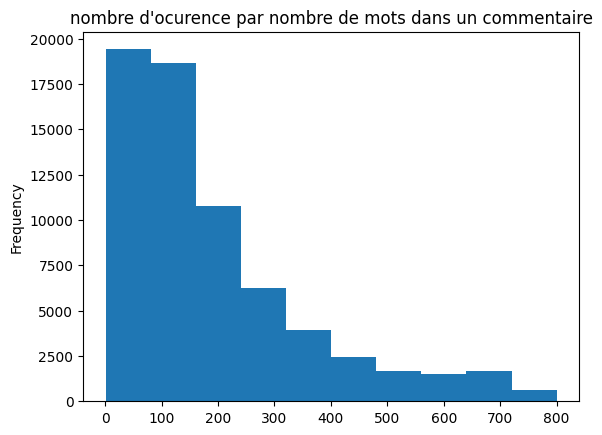

In [52]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()) if len(x.split())<800 else 800).plot(kind='hist', title="nombre d'ocurence par nombre de mots dans un commentaire")

In [53]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [66]:
#Select only the row with number of words greater than 250:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(0, 3)

In [55]:
#Select only the column 'consumer_complaint_narrative' and 'product'
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [56]:
#Group similar products
train_raw.loc[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.loc[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.loc[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.loc[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.loc[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [57]:
#all the different classes
for l in np.unique(train_raw['product']):
    print(l)

Bank account or service
Consumer Loan
Credit card or prepaid card
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfers
Mortgage
Other financial service
Payday loan, title loan, or personal loan
Student loan


In [58]:
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


## Data preprocessing and segmentation:

### 1. Preprocessing:
The preprocessing step goes as follows:
1. Remove all documents with fewer than 250 tokens. We want to concentrate only on long texts
2. Consolidate the classes by combining those that are similar. (e.g.: "Credit card" or "prepaid card" complaints) :
 * Credit reporting‘ to ‘Credit reporting, credit repair services, or other personal consumerreports‘.
 * ‘Credit card‘ to ‘Credit card or prepaid card‘.
 * ‘Payday loan‘ to ‘Payday loan, title loan or personal loan‘1
 * ‘Virtual currency‘ to ‘Money transfer, virtual currency or money servic
3. Remove all non-word characters
4. Encode the labels
5. Split the dataset in train set (80%) and validation set (20%).

### 2. Segmentation and tokenization:
First, each complaint is split into 200-token chunk with an overlap of 50 between each of them. This means that the last 50 tokens of a segment are the first 50 of the next segment.  
Then, each segment is tokenized using BERT's tokenizer. This is needed for two main reasons:
1. BERT's vocabulary is not made of just English words, but also subwords and single characters
2. BERT does not take raw string as inputs. It needs:
    - token ids: those values allow BERT to retrieve the tensor representation of a token
    - input mask: a tensor of 0s and 1s that shows whether a token should be ignored (0) or not (1) by BERT
    - segment ids: those are used to tell BERT what tokens form the first sentence and the second sentence (in the next sentence prediction task)  
    
The parameter `MAX_SEQ_LENGTH` ensures that any tokenized sentence longer that that number (200 in this case) will be truncated.  
Each returned segment is given the same class as the document containing it.

PyTorch offers the `Dataset` and `DataLoader` classes that make it easier to group the data reading and preparation operations while decreasing the memory usage in case the dataset is large.  
We implemented the above steps in the `Custom_Dataset_Class.py` file. Our dataset class `ConsumerComplaintsDataset1` has a constructor (`__init__`) taking the necessary parameters to load the .csv file, segment the documents, and then tokenize them. It also preprocesses the data as explained in the preprocessing section.    
The two other important methods are the following:
- `__len__` returns the number of documents
- `__getitem__` is the method where most of the work is done. It takes a tensor of idx values and returns the tokenized data:


&nbsp;


As said above, there is differents approaches for overflowing tokens, we added the differents strategies (described in [the following paper](https://arxiv.org/abs/1905.05583)) via the use of the parameter `approach` in the initialisation of Consumer Complaints Dataset class, here is the differents value of the `approach` parameter to handle that situation :
- **all**: overflowing tokens from a document are used to create new 200 token chunk with 50 tokens overlap between them
- **head**: overflowing tokens are truncated. Only the first 200 tokens are used.
- **tail**: only the last 200 tokens are kept.

In [59]:
TRAIN_BATCH_SIZE=8
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)

Loading BERT tokenizer...


Nettoyage des données


### 3. Fine-tuning on the 200 tokens chunks:
BERT is fine-tuned on the 200 tokens chunks

In our implementation, we put a neural network on top of the pooled output from BERT, each BERT's input token has a embeding as an output, the embedding of the `CLS` token (the first token) corresponds to the pooled output of the all sentence input (the 200 tokens chunk in our case).

The neural network is composed of a dense layer with a SoftMax activation function.

This Model corresponds to the class `Bert_Classification_Model` defined in the file `Bert_Classification.py`. This class inherits from `torch.nn.Module` which is the parent of all neural network models.

Then, in the function `train_loop_fun1` defined in `utils.py`, for each batch, the list of dictionaries containing the values for the token_ids, masks, token_type_ids, and targets are respectively concatenated into `torch.tensors` which are then fed into the model in order to get predictions and apply backpropagation according to the Cross Entropy loss.

#### First segmetation approach: all

in this approach, we will consider each chunk of 200 tokens as a new document, so if a document is split into 3 chunk of 200, tokens we will consider each chunks as a new document with the same label.\
We use this approach to fine tune BERT, so this model will be used as an input for RoBERT. 

![img/each_Chunk_as_Document.png](img/each_Chunk_as_Document.png)

In [60]:
device="cuda:2"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=Bert_Classification_Model().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t§§ model has been saved §§")
    torch.save(model, f"model1/model_epoch{epoch+1}.pt")    

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 


=============== EPOCH 1 / 3 ===============

___ batch index = 0 / 1715 (0.00%), loss = 2.1318, time = 0.28 secondes ___
___ batch index = 250 / 1715 (14.58%), loss = 0.8838, time = 45.34 secondes ___
___ batch index = 500 / 1715 (29.15%), loss = 0.7864, time = 44.90 secondes ___
___ batch index = 750 / 1715 (43.73%), loss = 0.7725, time = 45.09 secondes ___
___ batch index = 1000 / 1715 (58.31%), loss = 0.5372, time = 45.77 secondes ___
___ batch index = 1250 / 1715 (72.89%), loss = 0.6988, time = 46.60 secondes ___
___ batch index = 1500 / 1715 (87.46%), loss = 0.7093, time = 46.19 secondes ___

*** avg_loss : 0.75, time : ~5.0 min (313.13 sec) ***

==> evaluation : avg_loss = 0.57, time : 37.34 sec

=====>	{'accuracy': 0.8262952448545068, 'nb exemple': 11272, 'true_prediction': 9314, 'false_prediction': 1958}
	§§ model has been saved §§


RuntimeError: Parent directory model1 does not exist.

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

In [ ]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

##### Now we will experience the [Truncation strategies presented in this paper](https://arxiv.org/abs/1905.05583)

such as:  
* Tunction Method:  
    + Head only  
    + Tail only  
* Hierarchical Method:  
    + Mean pooling  
    + Max pooling  


### Truncation Methods

 
The Truncation methods applies to the input of the BERT model (the Tokens)
 
Usually, the key information of an article is at the beginning and end. We
use two different methods of truncate text to perform BERT fine-tuning


#### Second segmentation approach: head

in this approach, we will keep only the first chunk of 200 tokens for each documents, so if a document is split into 3 chunk of 200, we will only keep the first chunk and we will not keep the last two chunk.

![img/Head_Truncation.png](img/Head_Truncation.png)

In [ ]:
TRAIN_BATCH_SIZE=8
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

approach='head'

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN,
    approach=approach)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertConsumerComplaints().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ Truncation {approach} only model has been saved §§")
    torch.save(model, f"model_truncation/{approach}_only/model_{approach}_only_epoch{epoch+1}.pt")

#### Third segmetation approach: tail

in this approach, we will keep only the last chunk of 200 tokens for each documents, so if a document is split into 3 chunk of 200, we will only keep the last chunk and we will not keep the first two chunk.

![img/Tail_Truncation.png](img/Tail_Truncation.png)

In [ ]:
TRAIN_BATCH_SIZE=8
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000
approach='tail'

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN,
    approach=approach)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=BertConsumerComplaints().to(device)
optimizer=AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun1(train_data_loader, model, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun1(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ Truncation {approach} only model has been saved §§")
    torch.save(model, f"model_truncation/{approach}_only/model_{approach}_only_epoch{epoch+1}.pt")

### Hierarchical Method

the Hierarchical methods applies to the ouputs of the Bert model (the embbeding)
The input text is firstly divided into k = L/510 fractions, which is fed into BERT to obtain the representation of the k text fractions. The representation of each fraction is the hidden state of the `[CLS]` tokens of the last layer. Then we use mean pooling, max pooling


#### Mean Pooling 

in this approach, we average the embedding of all k chunks across each dimensions.

![img/Mean_Pooling_Hierarchical.png](img/Mean_Pooling_Hierarchical.png)

In [ ]:
TRAIN_BATCH_SIZE=3
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="mean"
model_hierarchical=BERT_Hierarchical_Model(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")
    torch.save(model_hierarchical, f"model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

#### Max Pooling 

in this approach, we take the maximum embedding of all the k chunks across each dimensions.

![img/Max_Pooling_Hierarchical.png](img/Max_Pooling_Hierarchical.png)

In [ ]:
TRAIN_BATCH_SIZE=3
EPOCH=1
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

pooling_method="max"
model_hierarchical=BERT_Hierarchical_Model(pooling_method=pooling_method).to(device)
optimizer=AdamW(model_hierarchical.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_hierarchical, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_hierarchical, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ the Hierarchical {pooling_method} pooling model has been saved §§")
    torch.save(model_hierarchical, f"model_hierarchical/{pooling_method}_pooling/model_{pooling_method}_pooling_epoch{epoch+1}.pt")    

# RoBERT RNN classifier on top of the Fine Tuned Bert Model

 The input text is firstly divided into k = L/510 fractions, which is fed into the fine tuned BERT (as describe above, *cf: First segmetation approach: all*) to obtain the representation of the k text chunks. The representation of each fraction is the hidden state of the `[CLS]` tokens of the last layer.
 
Each chunk embedding (representation) become the input of an LSTM cell, this way the order is preserved and the length of the document is not a limitation anymore because of the dynamic aspect of the LSTM that allow different variable sequence lengths (accros different batches)

we then pass the last hidden state (nbDoc * 100) to a neural network with the same architecture (as describe above, we use the same neural network architecture for classification through the all notebook, [cf: 3. Fine-tuning on the 200 tokens chunks](#3.-Fine-tuning-on-the-200-tokens-chunks:)) 

![img/RoBERT.png](img/RoBERT.png)

In [ ]:
TRAIN_BATCH_SIZE=3
EPOCH=3
validation_split = .2
shuffle_dataset = True
random_seed= 42
MIN_LEN=249
MAX_LEN = 100000
CHUNK_LEN=200
OVERLAP_LEN=50
#MAX_LEN=10000000
#MAX_SIZE_DATASET=1000

print('Loading BERT tokenizer...')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

dataset=ConsumerComplaintsDataset1(
    tokenizer=bert_tokenizer,
    min_len=MIN_LEN,
    max_len=MAX_LEN,
    chunk_len=CHUNK_LEN,
    #max_size_dataset=MAX_SIZE_DATASET,
    overlap_len=OVERLAP_LEN)


#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler,
    collate_fn=my_collate1)

valid_data_loader=DataLoader(
    dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler,
    collate_fn=my_collate1)


device="cpu"
lr=3e-5#1e-3
num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model=torch.load("model1/model_epoch2.pt")

model_rnn=RoBERT_Model(bertFineTuned=list(model.children())[0]).to(device)
optimizer=AdamW(model_rnn.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                        num_warmup_steps = 0,
                                        num_training_steps = num_training_steps)
val_losses=[]
batches_losses=[]
val_acc=[]
for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=rnn_train_loop_fun1(train_data_loader, model_rnn, optimizer, device)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=rnn_eval_loop_fun1(valid_data_loader, model_rnn, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")    
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print("\t§§ the RNN model has been saved §§")
    torch.save(model_rnn, f"model_rnn1/model_rnn_epoch{epoch+1}.pt")    

In [ ]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

In [ ]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

# Summary

In [ ]:
summary=pd.DataFrame({"all":[0.74, 0.57, 0.83], "head only":[0.62, 0.45, 0.87], "tail only":[0.93, 0.75, 0.77], "mean pooling":[0.62, 0.47, 0.87], "max pooling":[0.65, 0.45, 0.87], "RoBERT":[0.46, 0.34, 0.91]}, index=["avg_loss_train", "avg_loss_val", "accuracy"])
summary.columns.name = 'after one epoch'
summary.style.set_properties(
    subset=['RoBERT'], 
    **{'font-weight': 'bold'}
)

We can observe that the RoBERT Model give the best result, so we can conclude that this Model a net State Of the Art improvement in term of the loss function and the accuracy, the second model is the head only, this make sense because we can imagine that the consumer introduce his complain within the first part of his comment.